In [ ]:
import pandas as pd
import requests
import urllib.parse
#!pip install nrel-pysam
import pickle
import os, sys
import re
import matplotlib.pyplot as plt

In [ ]:
from google.colab import auth
auth.authenticate_user()
project_id = 'numeric-melody-308801'
%load_ext google.cloud.bigquery
!gcloud config set project {project_id}
!gsutil ls

Updated property [core/project].
gs://numeric-melody-308801.appspot.com/


In [ ]:
def pred_wind_power(windspeed_df, power_curve, temp_df=None, pressure_df=None):
    """Accepts dataframe with windspeeds (floats) at a certain location, Series with power produced at defined speeds.
    Returns DataFrame of 'Month' (1-12), output power ('kW'), in whatever timeframe submitted
    (eg. hourly, monthly, etc), assuming single 2MW turbine.
    Dependent on power_curve indexes equalling defined windspeed levels, and proper curve-class passed."""

    max_curve_speed = max(power_curve.index)
    windspeed = windspeed_df['wind speed at 100m (m/s)']

    lower_ws = windspeed.apply(int).apply(lambda s: s if s < max_curve_speed else 0).values
    upper_ws = lower_ws+1
    power_diff = power_curve.iloc[upper_ws].reset_index(drop=True).sub(power_curve.iloc[lower_ws].reset_index(drop=True))
    frac_power = power_diff.mul(windspeed.sub(windspeed.apply(int)))
    final_power = frac_power.add(power_curve.iloc[lower_ws].reset_index(drop=True)).rename('kW')

    return pd.concat([windspeed_df, final_power], axis=1)


In [ ]:
def pred_wind_power2(windspeed_df, power_curve, temp_df, pressure_df):
    """Accepts dataframe with windspeeds (floats) at a certain location, Series with power produced at defined speeds.
    Returns DataFrame of 'Month' (1-12), output power ('kW'), in whatever timeframe submitted
    (eg. hourly, monthly, etc), assuming single 2MW turbine.
    Dependent on power_curve indexes equalling defined windspeed levels, and proper curve-class passed.
    Using equation: density = (pressure Pa)/(temp K)(dry air gas constant 'Ro' J/kg*K)
    """

    max_curve_speed = max(power_curve.index)
    windspeed = windspeed_df['wind speed at 100m (m/s)']
    temp = temp_df['air temperature at 100m (C)'] + 273.15  # Convert to kelvin
    pressure = pressure_df['air pressure at 100m (Pa)']

    STP = 1.225  # kg/m^3
    Ro = 287.05
    density = pressure.div(temp.mul(Ro)).div(STP)

    lower_ws = windspeed.apply(int).apply(lambda s: s if s < max_curve_speed else 0).values
    upper_ws = lower_ws+1
    power_diff = power_curve.iloc[upper_ws].reset_index(drop=True).sub(power_curve.iloc[lower_ws].reset_index(drop=True))
    frac_power = power_diff.mul(windspeed.sub(windspeed.apply(int)))
    final_power = frac_power.add(power_curve.iloc[lower_ws].reset_index(drop=True))
    power_density = final_power.mul(density).rename('kW')

    return pd.concat([windspeed_df, power_density], axis=1)

In [ ]:
def pred_solar_power(solar_df, station_rated_output):
    """Accepts dataframe with Global Horizontal Irradiance (floats) at a certain location assuming in W/m^2,
    Scaler indicating output of plant in MW.
    ?Returns DataFrame of 'Month' (1-12), output power ('MW'), in whatever timeframe submitted
    """

    ghi = solar_df['GHI']   # GHI in W/m^2

    pred_power = ghi.div(800).mul(station_rated_output).rename('MW')

    return pd.concat([solar_df['Month'], pred_power], axis=1)

In [ ]:
directory = '/content/drive/MyDrive/Data Science Student Material/Capstone Project/Data/test/'

## BigQuery

In [ ]:
%%bigquery --project $project_id bqdf
SELECT 
  COUNT(*) as total_rows
FROM `numeric-melody-308801.nm_winds_100m.test`

In [ ]:
bqdf

## Wind Data

In [ ]:
wind_url = 'https://developer.nrel.gov/api/wind-toolkit/v2/wind/wtk-download.json?api_key=0WIF3emAV5iUrIyfYwk0Fcm5wUZGfwLVOlLD7Nc1'
#params_state  = '&wkt=POLYGON((-103.072391+36.940417%2C-109.014299+36.966740%2C-109.011065+32.066178%2C-103.128003+32.061526%2C-103.072391+36.940417))'
params_north   = '&wkt=POLYGON((-103.072391+36.98%2C-109.014299+36.98%2C-109.007507+35.7%2C-103.131484+35.7%2C-103.072391+36.98))'

#params_upper   = '&wkt=POLYGON((-103.131484+35.7%2C-109.007507+35.7%2C-109.007507+34.45%2C-103.131484+34.45%2C-103.131484+35.7))'
params_upper_north   = '&wkt=POLYGON((-103.131484+35.705%2C-109.007507+35.705%2C-109.007507+35.07%2C-103.131484+35.07%2C-103.131484+35.705))'
params_upper_south  = '&wkt=POLYGON((-103.131484+35.07%2C-109.007507+35.07%2C-109.007507+34.45%2C-103.131484+34.45%2C-103.131484+35.07))'

#params_upper_south_east   = '&wkt=POLYGON((-103.131484+35.705%2C-109.007507+35.705%2C-109.007507+34.45%2C-103.131484+34.45%2C-103.131484+35.705))'
#params_upper_south_west   = '&wkt=POLYGON((-106.00+35.07%2C-109.007507+35.07%2C-109.007507+34.45%2C-106.00+34.45%2C-106.00+35.07))'

params_lower   = '&wkt=POLYGON((-103.131484+34.45%2C-109.007507+34.45%2C-109.007507+33.20%2C-103.131484+33.20%2C-103.131484+34.45))'
params_south   = '&wkt=POLYGON((-103.131484+33.20%2C-109.007507+33.20%2C-109.011065+32.066178%2C-103.128003+32.061526%2C-103.131484+33.20))'
#params_bootheel   = '&wkt=POLYGON((-106.75+32.07%2C-109.01+32.07%2C-109.01+31.35%2C-108.22+31.35%2C-108.22+31.8%2C-106.6+31.8%2C-106.75+32.07))'

attributes = '&attributes=pressure_100m&names=2014&utc=false&leap_day=false&interval=60&email=kengustafson@gmail.com'

wind_res = requests.get(wind_url + params_south + attributes)

content = {}

if wind_res.status_code == 200:
    print(wind_res.headers['content-type'])

    content = wind_res.content

else:
    print('ERROR')

application/json; charset=utf-8


In [ ]:
pressure_south = wind_res.json()

In [ ]:
# Download data to local variable, then save to file

#nrel_res = requests.get('https://mapfiles.nrel.gov/data/wind/8ff95fad8f70284017c655f7e41e2de4.zip')
content = {}
if nrel_res.status_code == 200:
    print(nrel_res.headers['content-type'])
    content = nrel_res.content
else:
    print('ERROR')

In [ ]:
# Open a file
filepath = directory+'8ff95fad8f70284017c655f7e41e2de4.zip'
fd = os.open(filepath, os.O_CREAT|os.O_RDWR)

# Write contents
os.write(fd, content)

# Close file
os.close( fd )

In [ ]:
# Get data at a POINT

wind_url = 'https://developer.nrel.gov/api/wind-toolkit/v2/wind/wtk-download.json?api_key=0WIF3emAV5iUrIyfYwk0Fcm5wUZGfwLVOlLD7Nc1'
params_point   = '&wkt=POINT(-103.285278+32.952778)'
wind_attributes = '&attributes=windspeed_100m&names=2014&utc=false&leap_day=false&interval=60&email=kengustafson@gmail.com'
temp_attributes = '&attributes=temperature_100m&names=2014&utc=false&leap_day=false&interval=60&email=kengustafson@gmail.com'
pressure_attributes = '&attributes=pressure_100m&names=2014&utc=false&leap_day=false&interval=60&email=kengustafson@gmail.com'
all_attributes = '&attributes=windspeed_100m,temperature_100m,pressure_100m&names=2014&utc=false&leap_day=false&interval=60&email=kengustafson@gmail.com'

point_res = requests.get(wind_url + params_point + all_attributes)

content = {}
if point_res.status_code == 200:
    print(point_res.headers['content-type'])
    content = point_res.content
else:
    print('ERROR')

application/json; charset=utf-8


In [ ]:
point_res.json()['outputs']['downloadUrl']

'https://mapfiles.nrel.gov/data/wind/16e7e3956c89846f80343b8b16204208.zip'

## -Modify wind files; add lat/lng columns-

In [ ]:
files = os.listdir(path=directory + '17d32a62f10464f6ae3841d2026ec8cd/')

for file in files:
    id, lat, lng, year = file.split('_')
    #lat = file[7:12]
    #lng = file[13:20]
    df = pd.read_csv(directory + '17d32a62f10464f6ae3841d2026ec8cd/' + file, header=1)
    df['latitude'] = lat
    df['longitude'] = lng

    df['datetime'] = pd.to_datetime(
        df['Year'].apply(str)+'-'+
        df['Month'].apply(str)+'-'+
        df['Day'].apply(str)+' '+
        df['Hour'].apply(str)+':'+
        df['Minute'].apply(str)+':00', infer_datetime_format=True)
    
    df.rename(columns={'wind speed at 100m (m/s)':'windspeed'}, inplace=True)
    df.drop(labels=['Year', 'Month', 'Day', 'Hour', 'Minute'], axis=1, inplace=True)

    df.to_csv('/content/sample_data/' + '17d32a62f10464f6ae3841d2026ec8cd/' + file, index=False)

In [ ]:
df = pd.read_csv('/content/sample_data/' + '17d32a62f10464f6ae3841d2026ec8cd/' + files[0])
df

In [ ]:
# Copy files to Google Cloud Storage, for subsequent import into BigQuery

bucket = 'gs://numeric-melody-308801.appspot.com/'
source = '/content/sample_data/17d32a62f10464f6ae3841d2026ec8cd/*' #/8234b812172692f28e758302e6c7b2b0/9*'
!gsutil -m cp {source} {bucket}

In [ ]:
#!gsutil ls gs://numeric-melody-308801.appspot.com
#!gsutil -m rm gs://numeric-melody-308801.appspot.com/*

In [ ]:
"""
for VARIABLE in $(gsutil ls)
do
  echo $(gsutil du $VARIABLE | grep -v /$ | wc -l) $VARIABLE
done
"""

## Site Count

In [ ]:
sites_url = 'https://developer.nrel.gov/api/nsrdb/v2/site-count.json?api_key=0WIF3emAV5iUrIyfYwk0Fcm5wUZGfwLVOlLD7Nc1'
params = '&wkt=POLYGON((-103.072391+36.940417%2C-109.014299+36.966740%2C-109.011065+32.066178%2C-103.128003+32.061526%2C-103.072391+36.940417))'

#sites_res = requests.get(sites_url + params)

content = {}

if sites_res.status_code == 200:
    print(sites_res.headers['content-type'])

    content = sites_res.content

else:
    print('ERROR')

In [ ]:
sites_res.json()

## Wind Wind Plants

In [ ]:
power_plants = pd.read_csv('/content/drive/MyDrive/Data Science Student Material/Capstone Project/Data/Power_Plants.csv')
power_plants_nm = power_plants[power_plants['State']=='New Mexico'].copy()
power_plants_nm.drop(labels=['X', 'Y', 'OBJECTID', 'Code', 'Sector_Name', 'State', 'Zip',
       'Street_Address', 'PrimSource', 'Coal_MW',
       'NG_MW', 'Crude_MW', 'Hydro_MW', 'HydroPS_MW', 'Nuclear_MW', 'Solar_MW',
       'Data_Source', 'Geoth_MW', 'Battery_MW', 'Others_MW', 'Biomass_MW'], axis=1, inplace=True)
power_plants_nm.reset_index(inplace=True, drop=True)
power_curves = pd.read_csv('/content/drive/MyDrive/Data Science Student Material/Capstone Project/Data/wind_power_curves.csv')


In [ ]:
power_plants_nm

In [ ]:
power_curves

,Speed m/s,Class_1,Class_2,Class_3,Class_S97,MWT-1000-61
0,0,0.0,0.0,0.0,0,0
1,1,0.0,0.0,0.0,0,0
2,2,0.0,0.0,0.0,0,0
3,3,0.0,0.0,12.6,0,0
4,4,39.0,56.6,82.4,202,0
5,5,136.2,176.8,204.0,339,44
6,6,280.2,347.8,378.0,559,210
7,7,474.2,574.6,621.4,885,330
8,8,732.6,867.8,943.0,1345,485
9,9,1046.6,1213.2,1325.8,1880,670


## Estimate Wind Plant Outputs

In [ ]:
#'C1 > 8.5; 7.5 < C2 < 8.5; C3 < 7.5'

In [ ]:
pickle_data = pickle.load(open('/content/drive/MyDrive/Data Science Student Material/Capstone Project/Data Sets/dict_wind_data_m.p','rb'))

monthly_wind_actual = pd.DataFrame.from_dict(pickle_data)

In [ ]:
monthly_wind_actual[monthly_wind_actual['Year']=='2014']['Aragonne MWH'].sum()

263987.0

####**NM Wind Energy Center**

In [ ]:
nm_wec_all = pd.read_csv('/content/drive/MyDrive/Data Science Student Material/Capstone Project/Data/nm-wec-all.csv', header=1)
nm_wec_all['wind speed at 100m (m/s)'].mean()   # Indicates Class_2 turbines

7.9022168949771805

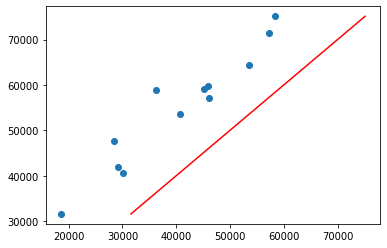

In [ ]:
pred_wind_nm_wec = pred_wind_power2(nm_wec_all, power_curves['Class_2'], nm_wec_all, nm_wec_all).groupby('Month').sum().reset_index(drop=True)['kW'] * 102/1000
act_wind_nm_wec = monthly_wind_actual[monthly_wind_actual['Year']=='2014']['NM Wind MWH'].sort_index(ascending=False).reset_index(drop=True)

plt.scatter(act_wind_nm_wec, pred_wind_nm_wec)
plt.plot([min(pred_wind_nm_wec), max(pred_wind_nm_wec)], [min(pred_wind_nm_wec), max(pred_wind_nm_wec)], c='red')

####**Caprock**

In [ ]:
caprock_all = pd.read_csv('/content/drive/MyDrive/Data Science Student Material/Capstone Project/Data/caprock-all.csv', header=1)
caprock_all['wind speed at 100m (m/s)'].mean()   # Indicates Class_1 turbines - Really Class_2 hardware

9.340486301369893

In [ ]:
pred_wind_caprock = pred_wind_power2(caprock_all, power_curves['MWT-1000-61'], caprock_all, caprock_all).groupby('Month').sum().reset_index(drop=True)['kW'] * 80/1000

act_wind_caprock = monthly_wind_actual[monthly_wind_actual['Year']=='2014']['Caprock MWH'].sort_index(ascending=False).reset_index(drop=True)

act_wind_caprock / pred_wind_caprock

0     0.909770
1     0.712252
2     0.972404
3     0.958575
4     0.984522
5     1.038930
6     0.763226
7     0.948749
8     0.955786
9     0.927828
10    0.938860
11    0.823735
dtype: float64

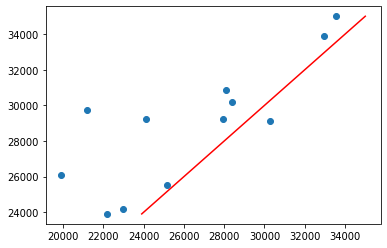

In [ ]:
plt.scatter(act_wind_caprock, pred_wind_caprock)
plt.plot([min(pred_wind_caprock), max(pred_wind_caprock)], [min(pred_wind_caprock), max(pred_wind_caprock)], c='red')

####**San Juan**

In [ ]:
san_juan_all = pd.read_csv('/content/drive/MyDrive/Data Science Student Material/Capstone Project/Data/san-juan-all.csv', header=1)
san_juan_all['wind speed at 100m (m/s)'].mean()   # Indicates Class_2 turbines

8.169867579908722

In [ ]:
pred_wind_san_juan = pred_wind_power2(san_juan_all, power_curves['MWT-1000-61'], san_juan_all, san_juan_all).groupby('Month').sum().reset_index(drop=True)['kW'] * 120/1000
act_wind_san_juan = monthly_wind_actual[monthly_wind_actual['Year']=='2014']['San Juan Mesa MWH'].sort_index(ascending=False).reset_index(drop=True)


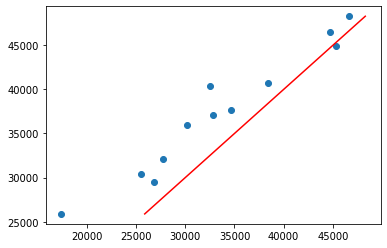

In [ ]:
plt.scatter(act_wind_san_juan, pred_wind_san_juan)
plt.plot([min(pred_wind_san_juan), max(pred_wind_san_juan)], [min(pred_wind_san_juan), max(pred_wind_san_juan)], color='red')

####**Red Mesa**

In [ ]:
red_mesa_all = pd.read_csv('/content/drive/MyDrive/Data Science Student Material/Capstone Project/Data/red-mesa-all.csv', header=1)
red_mesa_all['wind speed at 100m (m/s)'].mean()   # Indicates Class_2 turbines

8.028538812785353

In [ ]:
pred_wind_red_mesa = pred_wind_power2(red_mesa_all, power_curves['Class_2'], red_mesa_all, red_mesa_all).groupby('Month').sum()['kW'].reset_index(drop=True) * 51.2/1000
act_wind_red_mesa = monthly_wind_actual[monthly_wind_actual['Year']=='2014']['Red Mesa MWH'].sort_index(ascending=False).reset_index(drop=True)

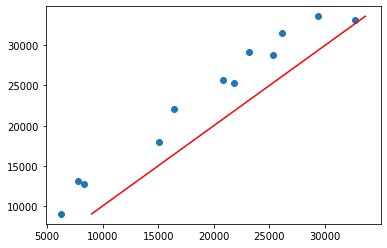

In [ ]:
plt.scatter(act_wind_red_mesa, pred_wind_red_mesa)
plt.plot([min(pred_wind_red_mesa), max(pred_wind_red_mesa)], [min(pred_wind_red_mesa), max(pred_wind_red_mesa)], color='red')

####**High Lonesome**

In [ ]:
high_lonesome_all = pd.read_csv('/content/drive/MyDrive/Data Science Student Material/Capstone Project/Data/high-lonesome-all.csv', header=1)
high_lonesome_all['wind speed at 100m (m/s)'].mean()   # Indicates Class_2 turbines

8.03893949771691

In [ ]:
pred_wind_high_lonesome = pred_wind_power2(high_lonesome_all, power_curves['Class_2'], high_lonesome_all, high_lonesome_all).groupby('Month').sum()['kW'].reset_index(drop=True) * 50/1000
act_wind_high_lonesome = monthly_wind_actual[monthly_wind_actual['Year']=='2014']['High Lonesome MWH'].sort_index(ascending=False).reset_index(drop=True)

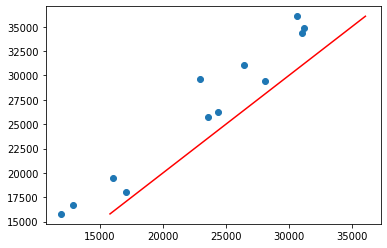

In [ ]:
plt.scatter(act_wind_high_lonesome, pred_wind_high_lonesome)
plt.plot([min(pred_wind_high_lonesome), max(pred_wind_high_lonesome)], [min(pred_wind_high_lonesome), max(pred_wind_high_lonesome)], color='red')

####**Aragonne**

In [ ]:
aragonne_all = pd.read_csv('/content/drive/MyDrive/Data Science Student Material/Capstone Project/Data/aragonne-all.csv', header=1)
aragonne_all['wind speed at 100m (m/s)'].mean()   # Indicates Class_1 turbines

8.660922374429187

In [ ]:
pred_wind_aragonne = pred_wind_power2(aragonne_all, power_curves['Class_1'], aragonne_all, aragonne_all).groupby('Month').sum()['kW'].reset_index(drop=True) * 45/1000
act_wind_aragonne = monthly_wind_actual[monthly_wind_actual['Year']=='2014']['Aragonne MWH'].sort_index(ascending=False).reset_index(drop=True)

In [ ]:
plt.scatter(act_wind_aragonne, pred_wind_aragonne)

plt.title(label='2014 Actual vs. Predicted Generation, Aragonne NM', pad=30)
plt.xlabel('Actual Output (MWh) by Month', labelpad=20)
plt.ylabel('Predicted Output (MWh) by Month', labelpad=20)

plt.plot([min(pred_wind_aragonne), max(pred_wind_aragonne)], [min(pred_wind_aragonne), max(pred_wind_aragonne)], color='red');

NameError: ignored

In [ ]:
pred_wind_aragonne = pred_wind_power(aragonne_all, power_curves['Class_1'], aragonne_all, aragonne_all).groupby('Month').sum()['kW'].reset_index(drop=True) * 45/1000
act_wind_aragonne = monthly_wind_actual[monthly_wind_actual['Year']=='2014']['Aragonne MWH'].sort_index(ascending=False).reset_index(drop=True)

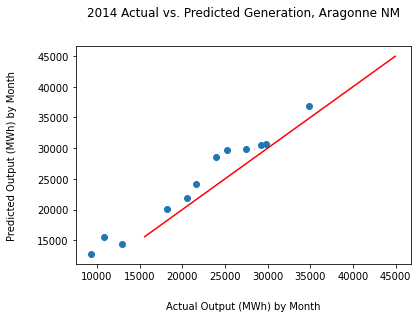

In [ ]:
plt.scatter(act_wind_aragonne, pred_wind_aragonne*0.82)

plt.title(label='2014 Actual vs. Predicted Generation, Aragonne NM', pad=30)
plt.xlabel('Actual Output (MWh) by Month', labelpad=20)
plt.ylabel('Predicted Output (MWh) by Month', labelpad=20)

plt.plot([min(pred_wind_aragonne), max(pred_wind_aragonne)], [min(pred_wind_aragonne), max(pred_wind_aragonne)], color='red');

####**Macho Springs**

In [ ]:
macho_springs_all = pd.read_csv('/content/drive/MyDrive/Data Science Student Material/Capstone Project/Data/macho-springs-all.csv', header=1)
macho_springs_all['wind speed at 100m (m/s)'].mean()   # Indicates Class_3 turbines

6.411804794520562

In [ ]:
pred_wind_macho_springs = pred_wind_power2(macho_springs_all, power_curves['Class_3'], macho_springs_all, macho_springs_all).groupby('Month').sum()['kW'].reset_index(drop=True) * 25.2/1000
act_wind_macho_springs = monthly_wind_actual[monthly_wind_actual['Year']=='2014']['Macho Springs MWH'].sort_index(ascending=False).reset_index(drop=True)

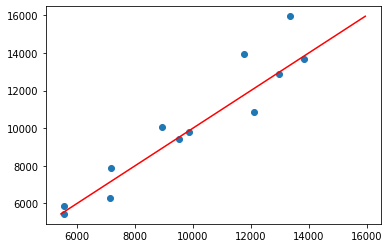

In [ ]:
plt.scatter(act_wind_macho_springs, pred_wind_macho_springs)
plt.plot([min(pred_wind_macho_springs), max(pred_wind_macho_springs)], [min(pred_wind_macho_springs), max(pred_wind_macho_springs)], c='red')

####**Wildcat**

In [ ]:
wildcat_all = pd.read_csv('/content/drive/MyDrive/Data Science Student Material/Capstone Project/Data/wildcat-all.csv', header=1)
wildcat_all['wind speed at 100m (m/s)'].mean()   # Indicates Class_3 turbines

7.499834474885824

In [ ]:
pred_wind_wildcat = pred_wind_power2(wildcat_all, power_curves['Class_S97'], wildcat_all, wildcat_all).groupby('Month').sum()['kW'].reset_index(drop=True) * 13/1000
act_wind_wildcat = monthly_wind_actual[monthly_wind_actual['Year']=='2014']['Wildcat MWH'].sort_index(ascending=False).reset_index(drop=True)

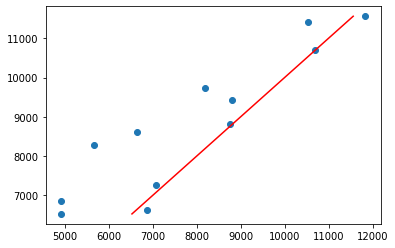

In [ ]:
plt.scatter(act_wind_wildcat, pred_wind_wildcat)
plt.plot([min(pred_wind_wildcat), max(pred_wind_wildcat)], [min(pred_wind_wildcat), max(pred_wind_wildcat)], color='red')

## Solar Data

In [ ]:
# Get solar at a POINT

solar_url = 'https://developer.nrel.gov/api/nsrdb/v2/solar/psm3-download.csv?api_key=0WIF3emAV5iUrIyfYwk0Fcm5wUZGfwLVOlLD7Nc1'
params_point = '&wkt=POINT(-106.913333+32.251667)'
attributes = '&attributes=dhi,dni,ghi&names=2019&utc=false&leap_day=false&interval=60&email=kengustafson@gmail.com'

point_res = requests.get(solar_url + params_point + attributes)

content = {}
if point_res.status_code == 200:
    print(point_res.headers['content-type'])
    content = point_res.content
else:
    print('ERROR')

text/csv


In [ ]:
# Open file
filepath = directory + '../solar-' + params_point[5:] + '.csv'
fd = os.open(filepath, os.O_CREAT|os.O_RDWR)
# Write contents
os.write(fd, content)
# Close file
os.close( fd )

## Estimate Solar Plant Outputs - 2019

In [ ]:
pickle_data = pickle.load(open('/content/drive/MyDrive/Data Science Student Material/Capstone Project/Data Sets/dict_solar_data_m.p','rb'))

monthly_solar_actual = pd.DataFrame.from_dict(pickle_data)
monthly_solar_actual[['Month', 'Year']] = monthly_solar_actual['Month'].str.split(expand=True)

In [ ]:
monthly_solar_actual

###SunE SPS5 Hopi

In [ ]:
solar_sun_hopi = pd.read_csv('/content/drive/MyDrive/Data Science Student Material/Capstone Project/Data/solar-POINT(Sun_Hopi_2019).csv', header=2)

In [ ]:
pred_solar_sun_hopi = pred_solar_power(solar_sun_hopi, 10.1).groupby('Month').sum().reset_index()

In [ ]:
act_solar_sun_hopi = monthly_solar_actual[monthly_solar_actual['Year']=='2019']['SPS5_Hopi PV MWH'].sort_index(ascending=False).reset_index(drop=True)

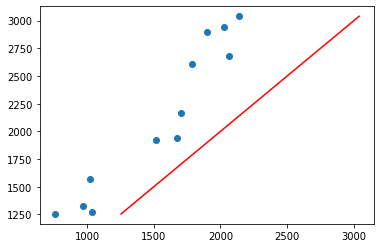

In [ ]:
plt.scatter(act_solar_sun_hopi, pred_solar_sun_hopi['MW'])
plt.plot([min(pred_solar_sun_hopi['MW']), max(pred_solar_sun_hopi['MW'])], [min(pred_solar_sun_hopi['MW']), max(pred_solar_sun_hopi['MW'])], color='red')

###Cimarron - 30 MW

In [ ]:
solar_cimarron = pd.read_csv('/content/drive/MyDrive/Data Science Student Material/Capstone Project/Data/solar-POINT(Cimarron_2019).csv', header=2)

pred_solar_cimarron = pred_solar_power(solar_cimarron, 30).groupby('Month').sum().reset_index()

In [ ]:
pickle_data = pickle.load(open('/content/drive/MyDrive/Data Science Student Material/Capstone Project/Data Sets/dict_solar_data_m.p','rb'))
monthly_solar_actual = pd.DataFrame.from_dict(pickle_data)
monthly_solar_actual[['Month', 'Year']] = monthly_solar_actual['Month'].str.split(expand=True)

act_solar_cimarron = monthly_solar_actual[monthly_solar_actual['Year']=='2019']['Cimmaron PV MWH'].sort_index(ascending=False).reset_index(drop=True)

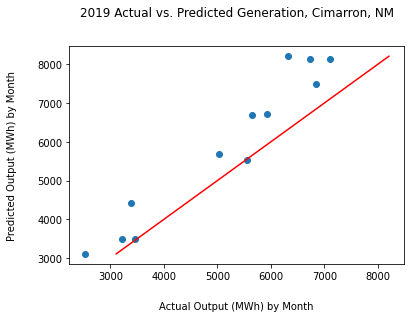

In [ ]:
plt.scatter(act_solar_cimarron, pred_solar_cimarron['MW'])
plt.title(label='2019 Actual vs. Predicted Generation, Cimarron, NM', pad=30)
plt.xlabel('Actual Output (MWh) by Month', labelpad=20)
plt.ylabel('Predicted Output (MWh) by Month', labelpad=20)
plt.plot([min(pred_solar_cimarron['MW']), max(pred_solar_cimarron['MW'])], [min(pred_solar_cimarron['MW']), max(pred_solar_cimarron['MW'])], color='red');

###Macho Springs

In [ ]:
solar_macho_springs = pd.read_csv('/content/drive/MyDrive/Data Science Student Material/Capstone Project/Data/solar-POINT(Macho_Springs_2019).csv', header=2)

pred_solar_macho_springs = pred_solar_power(macho_springs_2019, 55).groupby('Month').sum().reset_index()

In [ ]:
act_solar_macho_springs = monthly_solar_actual[monthly_solar_actual['Year']=='2019']['Macho Springs PV MWH'].sort_index(ascending=False).reset_index(drop=True)

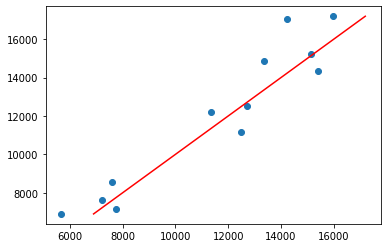

In [ ]:
plt.scatter(act_solar_macho_springs, pred_solar_macho_springs['MW'])
plt.plot([min(pred_solar_macho_springs['MW']), max(pred_solar_macho_springs['MW'])], [min(pred_solar_macho_springs['MW']), max(pred_solar_macho_springs['MW'])], color='red')

###Roadrunner


In [ ]:
solar_roadrunner = pd.read_csv('/content/drive/MyDrive/Data Science Student Material/Capstone Project/Data/solar-POINT(Roadrunner_2019).csv', header=2)

pred_solar_roadrunner = pred_solar_power(solar_roadrunner, 20).groupby('Month').sum().reset_index()

In [ ]:
act_solar_roadrunner = monthly_solar_actual[monthly_solar_actual['Year']=='2019']['Roadrunner PV MWH'].sort_index(ascending=False).reset_index(drop=True)

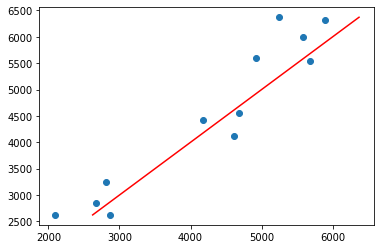

In [ ]:
plt.scatter(act_solar_roadrunner, pred_solar_roadrunner['MW'])
plt.plot([min(pred_solar_roadrunner['MW']), max(pred_solar_roadrunner['MW'])], [min(pred_solar_roadrunner['MW']), max(pred_solar_roadrunner['MW'])], color='red')

###SPS4_Monument PV MWH

In [ ]:
solar_monument = pd.read_csv('/content/drive/MyDrive/Data Science Student Material/Capstone Project/Data/solar-POINT(Monument_2019).csv', header=2)

pred_solar_monument = pred_solar_power(solar_monument, 10.1).groupby('Month').sum().reset_index()
act_solar_monument = monthly_solar_actual[monthly_solar_actual['Year']=='2019']['SPS4_Monument PV MWH'].sort_index(ascending=False).reset_index(drop=True)

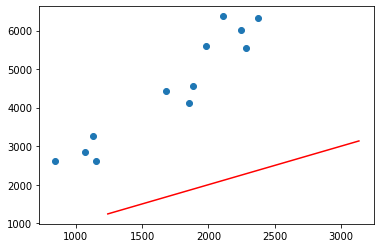

In [ ]:
plt.scatter(act_solar_monument, pred_solar_roadrunner['MW'])
plt.plot([min(pred_solar_monument['MW']), max(pred_solar_monument['MW'])], [min(pred_solar_monument['MW']), max(pred_solar_monument['MW'])], color='red')

###SunE_EPE2 PV MWH	/ Las Cruces

In [ ]:
solar_las_cruces = pd.read_csv('/content/drive/MyDrive/Data Science Student Material/Capstone Project/Data/solar-POINT(LasCruces_2019).csv', header=2)

pred_solar_las_cruces = pred_solar_power(solar_las_cruces, 12).groupby('Month').sum().reset_index()
act_solar_las_cruces = monthly_solar_actual[monthly_solar_actual['Year']=='2019'][' SunE_EPE2 PV MWH'].sort_index(ascending=False).reset_index(drop=True)

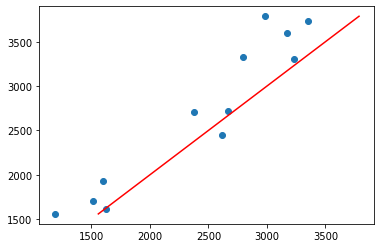

In [ ]:
plt.scatter(act_solar_las_cruces, pred_solar_las_cruces['MW'])
plt.plot([min(pred_solar_las_cruces['MW']), max(pred_solar_las_cruces['MW'])], [min(pred_solar_las_cruces['MW']), max(pred_solar_las_cruces['MW'])], color='red')